# Complaint Routing Model

### by Jeffrey Strickland, Ph.D.
#### 30 November 2019

## 1. Introduction
Banks are a prime example of businesses that already do or should take advantage of data science solutions to a variety of situations, including, but not limited to:
* Call routing for complex calls
* Call routing for complaints
* Quality control for regulatory compliance
* Customer sentiment analysis
* Fraudulent calls and other contacts

If we can select words and phrase from manuscripts or by actively monitoring calls, chats, and so on, then we can use past patterns to predict future behavior. We can also gauge customer sentiment when speaking to our best member service representatives (MSR), extract the words and phrases to characterize what "good looks like," and train other MSRs using the information we've obtained. Additionally, we can use the information to flag complex callers and route them to MSRs trained to address these situations. There are many other applications, but in this chapter, we will look at banks (financial services) we might deal with complaints about particular products or services, and (1) determine the product being complained about, and (2) predict future complains based on transcripts from past complaints.

### 1.1. Goal: Properly route complaints based on product groups. 
Our goal is to produce a data science solution that routes text complaints to the correct complaint department for each product group or service that the bank offers.

The bank's business unit receives complaints in the form of free text and wants to route the complaints to one of seven different complaint departments (with a product_group name in parenthesis):
	1. Bank account or service (bank_service)
	2. Credit card (credit_card)
	3. Credit reporting (credict_reporting)
	4. Debt collection (debt_collection)
	5. Lines of loans (loan)
	6. Money Transfers (money_transfers)
	7. Mortgage (mortgage)

We have obtained a data set with 286,362 records that contains complaint text (field name "text"), a message identifier ("complaint_id") and a verified correct complaint department ("product_group")

### 1.2. Methodology

We have obtained a data set with 286,362 records that contains complaint text (field name "text"), a message identifier ("complaint_id") and a verified correct complaint department ("product_group").

To start, we will use a variety of techniques to explore and process the data, but will essentially follow the typical natural language processing (NLP) methodology, we discussed in Chapter 1:
1.	Sentence Tokenization
2.	Word Tokenization
3.	Text Lemmatization and Stemming
4.	Stop Words
5.	Regular Expression (Regex)
6.	Term Frequency-Inverse document Frequency (TF-IDF)
7.	Bag-of-Words (BOW)

In this analysis, we use TF-IDF for two different functions, n-gram extraction and model fitting. For corpus feature extraction, we will create five different classification models (or text classifiers) and compare them using a set of metrics. The classifiers include:
    - Multinomial Naïve Bayes
    - RidgeClassifier
    - SGDClassifier 
    - Multinomial Logistic Regression
    - Random Forest (RP)
    - Support Vector Machine (SVM)
    - Multi-layer Perceptron Classifier (neural network)

For peforming NLP, we will use the bag-of-words (BOW) method.

## 2. Preliminaries
### 2.1. Load Required Packages
As is the case with all of our Python usage so far, we preload packages we think we will need, as one style of doing it. This has several advantages: we will be prompted to load updates so that we are using the current ones; Some of the package are global (used throughout), like maplotlib; and  it helps us think about our process as we begin. We will also load packages as we need them, just to show how we do it.

In [40]:
#Standard packages
import pandas as pd
import numpy as np
import matplotlib

# Scikit Learn
from sklearn import preprocessing
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer 
from sklearn.model_selection import train_test_split, KFold

#Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatiser = WordNetLemmatizer()

#Plotting
from matplotlib import pyplot as plt
import seaborn as sns
# Allow plots in Notebook
%matplotlib inline

#Warning supression
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### 2.2. Loading (reading) the Dataset using Pandas
Our first step in the modeling process is to load the data. In this instance the data is contained in a CVS file that we will read into the Jupyter Notebook.

In [41]:
dta = pd.read_csv("D:/Documents/Data/case_study_data_copy.csv")
df = dta[['complaint_id','product_group','text']]
corps = dta[['product_group','text']]

## 3. Data Exploration
The next several step we take are for exploring the complaint data, including listing the headings, viewing some records, and assessing the shape of the data frame. Often neglected, the shape of the data frame (or the dimensions of the array) will become important when we vectorize the independent variable, the text of the complaints. Also, it is a good idea to check that the data was loaded properly by examining a few records of rows of the data.

In [42]:
list(df), df.shape

(['complaint_id', 'product_group', 'text'], (263644, 3))

In [43]:
df.head(5) # for showing a snapshot of the dataset

,complaint_id,product_group,text
0,2815595,bank_service,On check was debited from checking account and...
1,2217937,bank_service,opened a Bank of the the West account The acco...
2,2657456,bank_service,in nj opened a business account without author...
3,1414106,bank_service,A hold was placed on saving account because in...
4,1999158,bank_service,Dear CFPBneed to send a major concerncomplaint...


### 3.1. Prepare a Frequency Distribution
Our next step is to gain an understanding of the data and its composition. We can do this by looking at the dependent variable, product groups. We can star with examining the frequency distribution of complaints by product. A good way to do this is studying the frequency distribution, or the count of complaints by group. Let's first examine the frequency distribution numerically. There are several ways to do this with Python. One way is to calculate the length of each complaint by product group, as shown below.

In [44]:
# Provides calculation of the shape of the data for each product group
bank_service_len = df[df['product_group'] == 'bank_service'].shape[0]
credit_card_len = df[df['product_group'] == 'credit_card'].shape[0]
credit_reporting_len = df[df['product_group'] == 'credit_reporting'].shape[0]
debt_collection_len = df[df['product_group'] == 'debt_collection'].shape[0]
loan_len = df[df['product_group'] == 'loan'].shape[0]
money_transfers_len = df[df['product_group'] == 'money_transfers'].shape[0]
mortgage_len = df[df['product_group'] == 'mortgage'].shape[0]

In [45]:
# Returns that complaint frequencies for each product group
bank_service_len, credit_card_len, credit_reporting_len, debt_collection_len, loan_len, money_transfers_len, mortgage_len 

(20071, 29553, 81232, 61471, 31036, 0, 40281)

Another way to getthe frquencies uf to call them directly as we have below.

In [46]:
corps_freq = corps.groupby('product_group').text.count()
corps_freq

product_group
bank_service        20071
credit_card         29553
credit_reporting    81232
debt_collection     61471
loan                31036
mortgage            40281
Name: text, dtype: int64

### 3.2. Plotting the Data
Now, we can plot the data and study it. Again, there are several different plots and a number of methods within each. Here, we will work with histograms and look at three way to implement them with Python.

### Basic Histogram
For this plot we simply use plot.bar and group the categories by product_group, which will give us a histogram. We have added code that will increase the default values, starting with the figure size or plt.figure(figure = [n,m]). You can play with the dimensons until you get the size and shape you want. Next, we added a title and x-y labels, as well as setting their font size. Finally, we increased the size of the axes labels using plt.xticks(fontsize = 14) and plt.yticks(fontsize = 14). plt.title() adds a plot title. plt.show() is the command to plots all the plotting objects that precede it.

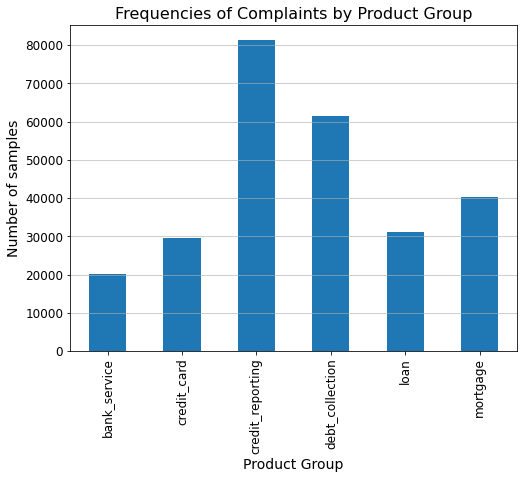

In [47]:
plt.figure(figsize=[8,6])
corps.groupby('product_group').text.count().plot.bar(ylim=0)
plt.grid(axis='y', alpha=0.75)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Number of samples', fontsize=14)
plt.xlabel('Product Group', fontsize=14)
plt.title('Frequencies of Complaints by Product Group', fontsize=16)
plt.show()

### Histogram with Legend using Matplotlib Only
Here we use the categories we defined above to add a legend, as well as chart title and axes labels. Using the previous method does not allow the addition of a legend. The print syntax is a little different. The first argument for *plt.bar* is where on the x-axis we place the bar (using 1-7 for the seven product groups). This positioning is arbitrary. For instance, we can plot the bank service bar as 5 instead of 1 and the frequencies do not change; however, it is a better practice to maintain the same order for the classes and we have been using alphabetical order. The second is the component we are plotting, a product group. The third is the width of the bar. The fourth is the label for the legend.

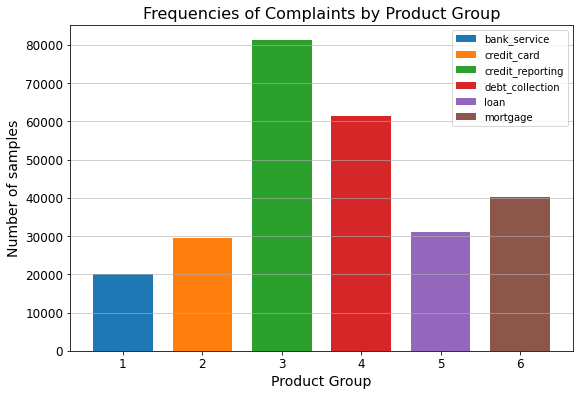

In [48]:
# Sets up the data for construct the frequency distribution (bar chart)
plt.figure(figsize=[9,6])
plt.bar(1,bank_service_len,0.75, label="bank_service")
plt.bar(2,credit_card_len,0.75, label="credit_card")
plt.bar(3,credit_reporting_len,0.75, label="credit_reporting")
plt.bar(4,debt_collection_len,0.75, label="debt_collection")
plt.bar(5,loan_len,0.75, label="loan")
plt.bar(6,mortgage_len,0.75, label="mortgage")
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Number of samples', fontsize=14)
plt.xlabel('Product Group', fontsize=14)
plt.title('Frequencies of Complaints by Product Group', fontsize=16)
plt.show()

### 3.3. Store Product Group Data

The next step, and optional one, is to store the data for each product group into its own object for later use (potentially). In doing so, we can now call out an individual product group to analyze. for example, if we want to see the first transcript corresponding to the product group, mortgages, and the fifth complaint corresponding to the product group, credit card, we write mtg[1] followed by ccd[5].

In [49]:
bks = df[df.product_group=="bank_service"]["text"].values
mtg = df[df.product_group=="mortgage"]["text"].values
crp = df[df.product_group=="credit_reporting"]["text"].values
ccd = df[df.product_group=="credit_card"]["text"].values
lon = df[df.product_group=="loan"]["text"].values
dct = df[df.product_group=="debt_collection"]["text"].values

In [50]:
mtg[1], ccd[5]

("We paid off our mortgage with on On the evening of received a letter stating that had to call them to cancel auto withdrawal of mortgage payment checked account and noticed that they had tried to withdraw the mortgage payment so we were charged insufficient funds charge called them and told them to cancel auto withdrawal On they tried to withdraw again We got another charge plus a recurring insufficient funds charge of So now we 're up to dollars in our account called again and the girl kept saying have no record of your call you never told us not to take the money and there nothing we can do about it you need to put a stop payment on your account Also that they would refund the fees So called bank and told them what was happening and she told me that sure they could put stop payments on those amounts but it would cost for each At this point told her to close account She said she could close it until paid the fees",
 'received Double Cash credit card statement for the month of which 

### 3.4. Define Variables
As we go forward with our analysis, we'll want to treat the data as having two variables, the text variable, X, is the independent variable and the product group, y, is the dependent variable. Since Python is case sensitive, we want an upper-case X and a lower-case y. We use this convention because y is a vector and X is generally an array or matrix.

In [51]:
X = corps['text']

In [52]:
y = corps['product_group']

### 3.5. Label Encoding of Classes:

This is a classification problem where the classes are the seven product groups as already mentioned. In our dataset, the class labels are non-numeric (bank_services, credit_card, credit_reporting, debt_collection, loan, money_transfers, and mortgage). To perform some quick exploratoy analysis we use LabelEncoder from Scikit-Learn to make the classes numeric, starting from 0 depicting each label in the alphabetic order i.e., (0 → bank_services, 1 → credit_card, 2 → credit_reporting, 3 → debt_collection, 4 → loan, 5 → money_transfers, and 5 → mortgage).

In [53]:
# Importing necessary libraries
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
yL = labelencoder.fit_transform(y)

In [54]:
print(labelencoder.fit_transform(y))

[0 0 0 ... 5 5 5]


### 3.6. Histogram of Procuct Groups using Labels
Now that we have a numeric representation of the product groups, we can construct a histogram. For this, we will use two separate plotting functions to provide a more informative histogram. First, we use pyplot from the matplotlib package to "outline" the histogram. Since are categories are discrete, we add an seaborn (alias sns) distribution plot that plots the actual discrete values (0 to 6) on the horizontal axis. We don't really need this plot, but it serves as another example for plotting histograms (or distribution plots as they are called in Seaborn).

Text(0, 0.5, 'Frequencies')

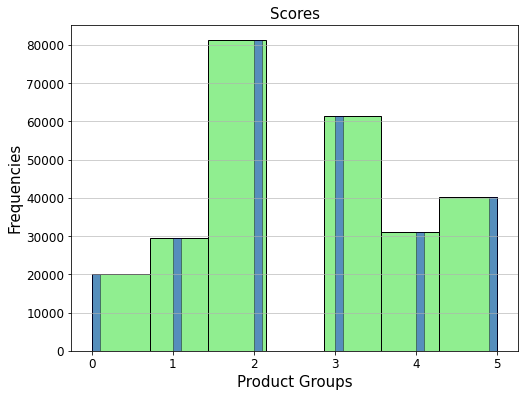

In [55]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.figure(figsize=[8,6])
plt.hist(yL, color = 'lightgreen', edgecolor = 'black',bins = 7)
# seaborn histogram
sns.distplot(yL, hist=True, kde=False, 
             bins=None, color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.grid(axis='y', alpha=0.75)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Scores',fontsize=15)
plt.xlabel('Product Groups',fontsize=15)
plt.ylabel('Frequencies',fontsize=15)


### 3.7. Word Cloud Visualization:

Word clouds are a way to show the frequency of words as they occur in the dependent variable, X. We have developed the word clouds as follows:

- Product groups have their own unique words and phrases, as well as some common ones
- Visualization of the mostly-used words to the least-used words for the product groups can be demonstrated
- Seven text snippets, each belonging to the seven product groups, respectively, can render a Word Cloud

In [56]:
# Importing necessary libraries
from PIL import Image
from wordcloud import WordCloud

wordcloud0 = WordCloud().generate(bks[1]) # for bank_service
wordcloud1 = WordCloud().generate(ccd[1]) # for credit_card
wordcloud2 = WordCloud().generate(crp[1]) # for credit_reporting 
wordcloud3 = WordCloud().generate(dct[1]) # for debt_collection 
wordcloud4 = WordCloud().generate(lon[1]) # for loan
wordcloud5 = WordCloud().generate(mtg[1]) # for mortgage


Bank Service


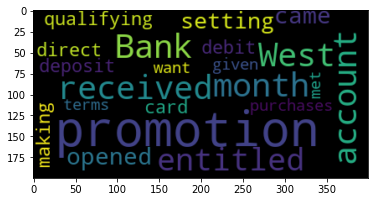

In [57]:
#print(X[0])
print('Bank Service')
plt.imshow(wordcloud0, interpolation='bilinear')
plt.show()

Credit Card


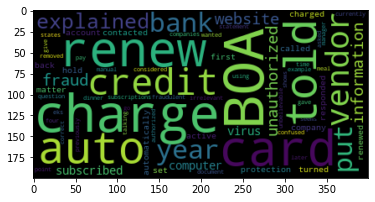

In [58]:
#print(X[22100])
print('Credit Card')
plt.imshow(wordcloud1, interpolation='bilinear')
plt.show()

Credit Reporting


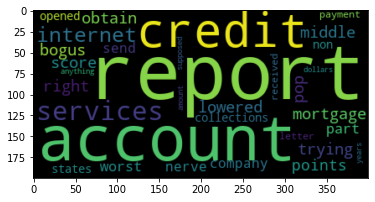

In [59]:
#print(X[42000])
print('Credit Reporting')
plt.imshow(wordcloud2, interpolation='bilinear')
plt.show()

Debt Collection


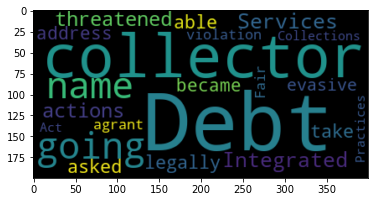

In [60]:
#print(X[152100])
print('Debt Collection')
plt.imshow(wordcloud3, interpolation='bilinear')
plt.show()

Loan


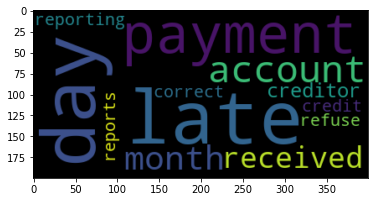

In [61]:
#print(X[199100])
print('Loan')
plt.imshow(wordcloud4, interpolation='bilinear')
plt.show()

Mortgage


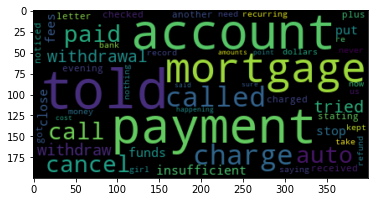

In [62]:
#print(X[237100])
print('Mortgage')
plt.imshow(wordcloud5, interpolation='bilinear')
plt.show()

## 4. Natural Language Processing (NLP)
In this section we will examine how various natural language processing techniques can provide productive insights into large collections of text data. In this instance, we continue to analyze the complaint data but with much more robust measures and results. As we have already posed, NLP is the process of turning human speech (usually in written form) into language a computer can understand (numerical) using a program, extracting information from the numerical representation of the language, and turning it back into informative human language.

We looked at the basic text preparation steps in Chapter 1. We add four more step for featyre extraction here:
1. Remove punctuation
2. Remove special characters
3. Remove stop words
4. Tokenize the text
5. Lemmatize the text
6. Vectorize the text
7. Perform text transformations
8. Extract n-grams

Here, will make better use of the power of Python and supporting packages, like Scikit-Learn (sklearn). These 'utilities" allow us to take a given text or collection of texts, a corpus), remove punctuation, remove white-spaces, convert to lower case, remove common words that yield no information (stopwords) to produce a "clean" version of the text we want to analyze. we will begin by discussing stopwords.

### 4.1. Stop Words
A stop word or stopword is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

There are several different ways to process text for stopwords with Python, including the Natural Language Tool Kit (NLTK) and Skikit-Learn (SKLearn). We could also build our own list and implement it by wring python code to remove stopwords using our list, of adapting a list and adding or taking from it for our use. However, processing text for stopwords is not simply a matter of pressing the Run button.

The are many existing stopwords lists and in many languages. In at least one of these lists is the word "computer," a word you may not want to remove, when analyzing text about competing technologies. Likewise, with save when analyzing retail banking issues. Stopwords from Skikit-Learn can be called after importing them, while NTLK stopwords are called within the CountVeterizor()function, which we will get to later in this section.

When we invoke stopwords with CountVectorizer, one of the arguments is, stopwords = None, as the default. If we want English stopwords, we merely add the argument, stopwords = 'english'.

#### Customized Stop Words
We will defer implementing the removal of stopwords until our discussion of CountVectorizer. For now, let's look at a list of stopwords I adapted from R. I added 'non-words' like "uh-huh", "um", "lol", and do on. In some settings, these might be appropriate words for analysis, but we usually exclude them and others like them.

In [63]:
stopwords = pd.read_csv("D:/Documents/Data/english_stopwords.txt")
print(stopwords)

Empty DataFrame
Columns: ['i',  'll',  'me',  'my',  'myself',  'we',  'our',  'ours',  'ourselves',  'you',  "you're",  "you've",  "you'll",  "you'd",  'your',  'yours',  'yourself',  'yourselves',  'he',  'him',  'his',  'himself',  'she',  "she's",  'her',  'hers',  'herself',  'it',  "it's",  'its',  'itself',  'they',  'them',  'their',  'theirs',  'themselves',  'what',  'which',  'who',  'whom',  'this',  'that',  "that'll",  'these',  'those',  'am',  'is',  'are',  'was',  'were',  'be',  'been',  'being',  'have',  'has',  'had',  'having',  'do',  'does',  'did',  'doing',  'a',  'an',  'the',  'and',  'but',  'if',  'or',  'because',  'as',  'until',  'while',  'of',  'at',  'by',  'for',  'with',  'about',  'against',  'between',  'into',  'through',  'during',  'before',  'after',  'above',  'below',  'to',  'from',  'up',  'down',  'in',  'out',  'on',  'off',  'over',  'under',  'again',  'further',  'then', ...]
Index: []

[0 rows x 183 columns]


In [64]:
# Importing necessary libraries
# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords

### 4.2. Lemmatization
Inflected forms of a word are known as lemma. For example, "studying," "studied" are inflected forms or lemma of the word study which is the root word. So, the lemma of a word are grouped under the single root word. This is done to make the vocabulary of words in the corpus contain distinct words only.

Lemmatization is the process of converting a word to its base form. Lemmatization igoes beyond stemming, since lemmatization considers the context and converts the word to its meaningful base form--stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.

### 4.3. Create Train and Test Sets
Before we proceed further, we will setup training and testing sets that we will use for feature selection with the classification methods we pre-selected (Multinomial Naive Bayes, Support Vector Machines, etc.). Once we have these sets defined, with will begin working on feature extraction. 

We will use the Scikit-Learn modules model.selection.train_test_split to establish these sets. The module splits arrays or matrices into random train and test subsets, by setting the size (percentage) of the test set. Here we want a training set that is comprised by 70&% of the test data, with the remaining 30% held as the testing set. Also, we want to have separate sets for the text, X (complaints), and the categories, y (product groups), as we will only need to prepare the text, X, using NLP. We will separately prepare the dependent variable, y, converting the word-classes to numeric categories.

Apart from the import statement, the first for steps have been performed previously. We repeat them here to to refresh the data for our NLP work. This fifth line is the code for splitting X and y to for the train and ets sets.

In [65]:
from sklearn.model_selection import train_test_split
dta = pd.read_csv("D:/Documents/Data/case_study_data_copy.csv",encoding = "ISO-8859-1")
df = dta[['product_group','text']]
X, y = df.text.fillna(' '), df.product_group
#X = corps.text
#y = df.product_group
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

### 4.4. Feature Extraction
The Scikit-Learn module, sklearn.feature_extraction, can be used to extract features in a format supported by machine learning algorithms from datasets consisting of formats such as text and image. However, this is not the same thing as feature selection, which is our goal when modeling, particularly when we want to predict future outcomes based on past data and feature selection. In our analysis here, we are just examine the text to see features exist that could help classify the text (complaints) that are unique to each (or any) of the product groups.

In [66]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### 4.5. Vectorization 
Vectorization is the process of converting data into a mathematical construct, like a vector, that can be easily manipulated without changing its content. Vectorization also speeds up computation. We usually evaluate the efficiency of a program by how fast it can manipulate large data sets in a relatively short time interval. Python uses mathematical functions for fast operations on entire arrays of data without having to write loops, and consequently produce results faster.

#### CountVectorizer
CountVectorizer converts text to word count vectors. It provides a simple way to both tokenize a collection of text documents, like our collection of complaints, and build a vocabulary of frequently used words, where the frequency can range from 1… n, known words. This vocabulary of known words can then be used to encode new related documents for analysis. In this manner, we can use a collection of text (complaints) to predict complaints based on this encoding. In our particular case, we will encode the text in such a manner as to not only predict complaints, but to categorize those complaints as belonging to one of the banks services/products, i.e., loans, credit cards, debt collection, and so on.
Here, we will use CountVectorizer to:
1.	Create an instance of the *CountVectorizer* function
2.	Call the *fit()* function to learn a vocabulary from one or more documents
3.	Call the *transform()* function on one or more documents as needed to encode each as a vector 

The pseudocode for this might appear as:
* Create the transform using vectorizer = CountVectorizer()
* Tokenize and build the vocabulary with vectorizer.fit(text)
* Summarized the results of vectorization using print(vectorizer.vocabulary_) [this function accesses the vocabulary to see what exactly was tokenized ]
* Encode the document with vector = vectorizer.transform(text)
* Summarize the encoded vector using print(vector.shape), print(type(vector)), and print(vector.toarray())

An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document, hence the “count” in vectorize. Now, these vectors will contain a lot of zeros, which we call them sparse vectors. However, Python provides an efficient way of handling sparse vectors using the *scipy.sparse* package. So, the vectors returned from a call to *transform()* function are sparse vectors, and we can transform them back to numpy arrays. We can then examine them to better understand what occurs by using the *toarray()* function.



In [29]:
from sklearn.feature_extraction.text import CountVectorizer

CountVectorizer(
    input='corps',            #the input text data or corpus
    encoding='utf-8',         #encoding is used to decode
    decode_error='strict',    #means a UnicodeDecodeError will be raised (other values are ignore and replace) 
    strip_accents='ascii',    #removes accents and perform other character normalization (ascii is the fastest)
    lowercase=True,           #converts all tect to lower case
    tokenizer=word_tokenize,  #default value is None (only applies if analyzer == 'word')
    stop_words='english',     #default value is None (only applies if analyzer == 'word')
    token_pattern=r'\b\w+\b', #string, denoting what constitutes a “token” (only used if analyzer == 'word')
    ngram_range=(1, 3),       #will yield unigrams, bigrams, and trigrams
    analyzer='word',          #feature makeup {‘string’, ‘word’, ‘char’, ‘char_wb’} or callable
    max_df=1.0,               #ignore terms that have a frequency higher than this threshold
    min_df=1,                 #ignore terms that have a frequency lower than this threshold
    max_features = 20,        #build a vocabulary size N or None
    binary=False,             #if True, all non zero counts are set to 1
    dtype= np.int64           #type of the matrix returned by fit_transform() or transform()
)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='corps',
                lowercase=True, max_df=1.0, max_features=20, min_df=1,
                ngram_range=(1, 3), preprocessor=None, stop_words='english',
                strip_accents='ascii', token_pattern='\\b\\w+\\b',
                tokenizer=<function word_tokenize at 0x000002A8AF9B2CA8>,
                vocabulary=None)

#### Term Frequency–Inverse Document Frequency
The *TfidfTransformer* function transforms a count matrix to a normalized term frequency (tf) or term frequency times inverse document frequency (tf-idf ) representation. This is a common term weighting scheme in information retrieval, that has also found good use in document classification. The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently. We use this transform because frequently occurring tokens in a given corpus are empirically less informative than features that occur in a small fraction of the training corpus.

The formula that is used to compute the tf-idf for a term *t* of a document *d* in a document set is *tf-idf(t, d) = tf(t, d) * idf(t)*, and the *idf* is computed as *idf(t) = log [ n / df(t) ] + 1* (if smooth_idf=False), where *n* is the total number of documents in the document set and *df(t)* is the document frequency of *t*; the document frequency is the number of documents in the document set that contain the term *t*. The effect of adding “1” to the idf in the equation above is that terms with zero *idf*, i.e., terms that occur in all documents in a training set, will not be entirely ignored. (Note that the *idf* formula above differs from the standard textbook notation that defines the *idf* as *idf(t) = log [ n / (df(t) + 1) ])*.

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer

TfidfTransformer(
    norm ='l2',          #each output row will have unit norm, either: 'l2', 'l1', or None
    use_idf=True,        #enable inverse-document-frequency reweighting
    smooth_idf=True,     #smooth idf weights by adding one to document frequencies to prevent divison by zero
    sublinear_tf=False,  #apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)
)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

## 5. Dicrete Classifiers
### 5.1. Naïve  Bayes Classification
Naïve Bayes is a very simple and reliable way to analyze how well text can be used to predict outcomes. In our case, we want to determine if the complaint data can be used to accurately classify and the predict the complaints by back services/product. In other words, can we use the present encoded complaint data to determine if a new complaint is correctly classified as a debt collect complaint, for example.

Here, we invoke yet another Scikit-Learn function, MultinomialNB(). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work, and we assume that here as well. MultinomialNB() has several functions:
* Fit function takes on two arguments: X, y or X-train, y_train when training a model.
* Get_params retrieves the parameters for this estimator.
* Predict function perform classification on an array of test vectors X, i.e., X_test.
* Predict_proba returns the probability estimates for the test vector X.
* Predict_log_proba returns the log-probability estimates for the test vector X
* Score function returns the mean accuracy on the given test data and labels.


In [67]:
from sklearn.naive_bayes import MultinomialNB

mnb_clf = MultinomialNB(
    alpha=1.0,        #additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
    class_prior=None, #prior probabilities of the classes. If specified, priors are not adjusted according to the data. 
    fit_prior=True    #whether to learn class prior probabilities or not, false = uniform prior will be used.
)

### 5.2. Pipeline Definition
Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification.

The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For this, it enables setting parameters of the various steps using their names and the parameter name separated by a '__', as in the example below. A step’s estimator may be replaced entirely by setting the parameter with its name to another estimator, or a transformer removed by setting it to 'passthrough' or None.

A Pipeline provides:
* Convenience and encapsulation: allows us to call fit and predict once on our data to fit a whole sequence of estimators.
* Joint parameter selection: allow us to grid search over parameters of all estimators in the pipeline at once.
* Safety: pipelines help avoid "leaking" statistics from our test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.).

In [32]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf_trans', TfidfVectorizer()),
     ('mnb_clf', MultinomialNB()),
 ])

For our problem, we have already defined CountVectorizer(), TfidfTransformer(), and MultinomialNB(), so we could point to those functions with their represenations, e.g., tfidf.fit_transform(X_train). However, we will not need these until later. For now, we turn to an alternative approach.

### 5.3. Product-to-Category and Category-to-Product Definition
If we were just concerned with generating information about complaints, we would not have to perform this step. We would merely call the n-grams from text with the CountVectorizer function. However, we want to encode the text in such a manner that we can identify complaints related to one of the bank services/products. Consequentially, we need to take the complaint about debt collection, and not only tokenize and transform the complaint text, but also assign a number to the category, debt collection. For example, the code we use below assigns 'zero' to the category 'bank services'. By calling the function category_to_id.items(), we can see all the category numeric assignments as shown below.

In [68]:
df = corps
df = df[pd.notnull(df['product_group'])]
df.columns = ['product_group','text']
df['category_id'] = df['product_group'].factorize()[0]
category_id_df = df[['product_group', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'product_group']].values)
df.head()

,product_group,text,category_id
0,bank_service,On check was debited from checking account and...,0
1,bank_service,opened a Bank of the the West account The acco...,0
2,bank_service,in nj opened a business account without author...,0
3,bank_service,A hold was placed on saving account because in...,0
4,bank_service,Dear CFPBneed to send a major concerncomplaint...,0


Again, by calling the function category_to_id.items(), we can see all the category numeric assignments:

In [69]:
category_to_id.items()

dict_items([('bank_service', 0), ('credit_card', 1), ('credit_reporting', 2), ('debt_collection', 3), ('loan', 4), ('mortgage', 5)])

### 5.4. TfidfVectorizer
This feature extraction function converts a collection of raw documents to a matrix of TF-IDF features. It is equivalent to invoking CountVectorizer followed by TfidfTransformer. The parameters for the function are the combined parameters from CountVectorizer and TfidfTransformer with the same definitions. For this problem, it makes more sense to use the TfidfVectorizer function. The reason for this is the process of extracting n-grams from the text requires the greater functionality provided, as we will want to use the same construct to define "features" and to pull "feature names" from. (See Extracting N-grams, below.)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

TfidfVectorizer(
    input='corps',            #the input text data or corpus
    encoding='utf-8',         #encoding is used to decode
    decode_error='strict',    #means a UnicodeDecodeError will be raised (other values are ignore and replace) 
    strip_accents='ascii',    #removes accents and perform other character normalization (ascii is the fastest)
    lowercase=True,           #converts all tect to lower case
    tokenizer=word_tokenize,  #default value is None (only applies if analyzer == 'word')
    stop_words='english',     #default value is None (only applies if analyzer == 'word')
    token_pattern=r'\b\w+\b', #string, denoting what constitutes a “token” (only used if analyzer == 'word')
    ngram_range=(1, 3),       #will yield unigrams, bigrams, and trigrams
    analyzer='word',          #feature makeup {‘string’, ‘word’, ‘char’, ‘char_wb’} or callable
    max_df=1.0,               #ignore terms that have a frequency higher than this threshold
    min_df=1,                 #ignore terms that have a frequency lower than this threshold
    max_features = 20,        #build a vocabulary size N or None
    binary=False,             #if True, all non zero counts are set to 1
    dtype= np.int64,          #type of the matrix returned by fit_transform() or transform()
    norm='l2',                #each output row will have unit norm, either: 'l2', 'l1', or None
    use_idf=True,             #enable inverse-document-frequency reweighting
    smooth_idf=True,          #smooth idf weights by adding one to document frequencies to prevent divison by zero
    sublinear_tf=False,       #apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)
)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='corps',
                lowercase=True, max_df=1.0, max_features=20, min_df=1,
                ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents='ascii',
                sublinear_tf=False, token_pattern='\\b\\w+\\b',
                tokenizer=<function word_tokenize at 0x000002A8AF9B2CA8>,
                use_idf=True, vocabulary=None)

### 5.5. Extracting N-Grams
Extracting N-grams is made easy using CountVectorizer() and TfidfVectorizer(). However, this problem requires a little more beyound merely calling N-grams, or extracting features. For this problem, we want to get N-grams for each complait category, i.e., bank servic, debt collection, and so on. We have already set ourselves up for success in the previous section on Product-to-Category and Category-to-Product Definition, as well as the vectorization we have already performed. Where one may run into difficulties implementing this technique is to not pay attention to dimensions or shapes after vectorization, as the vectors are going to be operated on using matrix algebra, and dimension must have the right shape for the resulting veatcor. This error would be most likely to occur in the first statement under the "for product group...

We define TfidfVectorizer() and use it to fit our training set. Then, in the "for" loop, we use it with the get_feature_name method in a numpy array, and we get the features that are evaluated to be n-grams from the complaints text. The rest of the code is for printing the output, n-grams for each product group.

In [70]:
#DO NOT CHANGE#
tfidf= TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(X_train) #CORRECT TRANSFORM
labels = y_train #CORRECT LABEL

MemoryError: 

In [40]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for product_group, category_id in sorted(id_to_category.items()):
  features_chi2 = chi2(features,labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("# '{}':".format(category_id))
  print(".   Most correlated unigrams:\n.     {}".format('\n.     '.join(unigrams[-N:])))
  print(".   Most correlated bigrams:\n.     {}".format('\n.     '.join(bigrams[-N:])))
  print(".   Most correlated trigrams:\n.     {}".format('\n.     '.join(trigrams[-N:])))

# 'bank_service':
.   Most correlated unigrams:
.     deposit
.     overdraft
.   Most correlated bigrams:
.     overdraft fees
.     checking account
.   Most correlated trigrams:
.     charged overdraft fees
.     opened checking account
# 'credit_card':
.   Most correlated unigrams:
.     express
.     card
.   Most correlated bigrams:
.     american express
.     credit card
.   Most correlated trigrams:
.     credit card account
.     credit card company
# 'credit_reporting':
.   Most correlated unigrams:
.     experian
.     equifax
.   Most correlated bigrams:
.     credit file
.     credit report
.   Most correlated trigrams:
.     mistakes appear report
.     appear report understanding
# 'debt_collection':
.   Most correlated unigrams:
.     collection
.     debt
.   Most correlated bigrams:
.     collect debt
.     collection agency
.   Most correlated trigrams:
.     attempting collect debt
.     trying collect debt
# 'loan':
.   Most correlated unigrams:
.     loans
.     

## 6. Bag-of-Words (BOW) Preparation

### 6.1. About Bag of Words
A bag-of-words (BOW) is basically the procedure we have been been performing:
1. Clean the text
2. Tokenize the text
3. Build a vocabulary from the text
4. Generate vextors from the text

With Bag-of-Words a vocabulary of words present in the corpus is maintained, and these words serve as features for each instance or document (each complaint). For words in the current document, we use their frequencies to develop features with NLP. In this way word features are engineered or extracted from the textual data or corpus.

### 6.2. Feature Engineering using Bag-of-Words
To develop feature from text is a very relevant issue for data science. Machine Learning Algorithms work only on numeric data, but for the problem we are solving, data is present in the form of text only. to perform our analysis, textual data needs to be transformed into numeric form. We call this process Feature Engineering. In this approach, numeric features are extracted or engineered from textual data. There are many Feature Engineering Techniques in existence, but for this problem we will use the Bag-of-Words model to engineer features.

We have already seen the process of cleaning data using feature extraction function from Scikit-Learn, and we will use these function again, which is repeative, but the best way to learn something is to do it more than once. In particular, we will use TfidfTransformer() and CountVectorizer() with the complaint data and the training and test sets we have aleady defined. 

### 6.3. Vectorizing the Complaints
Once again, we define CountVectorizer() to convert thr collection of complaints (text) to a matrix of token counts, which we can use in a Bayes Classifier. The vectorizer we difine here will essentially put the words in a bag on nunbers representing the words. The output, text_bow_train and text_bow_text, will be used in the next step.

In [41]:
vectorizer = CountVectorizer()
bow_transformer_train=CountVectorizer().fit(X_train)
bow_transformer_test=CountVectorizer().fit(X_test)

bow_transformer=vectorizer.fit(X_train)
text_bow_train=bow_transformer.transform(X_train)#ONLY TRAINING DATA
text_bow_test=bow_transformer.transform(X_test)#ONLY TEST DATA

## 7. BOW with a Multinomial Bayes Classifier
Finally, we define the MultinomialNB() to perform a fit of X_train and y_train, which we use as a classifier model. For simplicity, we will continue to use CountVectorizer(), but we'll name the output suing "bow" in the name. For example, the vectorizer with become "bow_transformer", and the X_train data will become "text_bow_train". Otherwise, the procedure is the same, except that we add so called "confusion matrices" to further visualize and analyze performance.

In [42]:
# instantiating the model with Multinomial Naive Bayes..
mnb_clf = MultinomialNB()

# training the model...
mnb_clf = mnb_clf.fit(text_bow_train, y_train)

print(mnb_clf)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


### 7.1. Classifier Training Score
We now compute the score for the trained classifier model. Score return the mean accuracy on the given training or test data and labels. Yet, this is just a sanity check and not the score we want. We get the score of interest when we use the classifier to predict the predict group complaints using the two test sets, X_test and y_test.

In [43]:
mnb_clf.score(text_bow_train, y_train)

0.8205210096558185

### 7.2. Classifier Prediction
Now that we have the the fitted model, mnb_clf, we test its predictions, and measure its accuracy and performance. Notice that we only need to call the 'mnb_clf' from the pipeline both to fit and predict. Then, we check the accuracy of our predictions using the the score module as we did above.

In [46]:
# Predict Outcomes using the MultinomialNB() model
y_pred = mnb_clf.predict(text_bow_test)
y_pred

array(['credit_reporting', 'credit_card', 'credit_reporting', ...,
       'credit_card', 'bank_service', 'debt_collection'], dtype='<U16')

### 7.3 Classifier Testing Score
Now, we scor the model predictions for accuracy.

In [100]:
mnb_clf.score(text_bow_test, y_test), accuracy_score(y_test, y_pred, normalize=True)

(0.8103683831383361, 0.8150632188190874)

### 7.4. Performance
Next, we conduct a more comprehensive performance test comprised of precision, recall, support, and f1-score metrics.

In [48]:
from sklearn import metrics
vectorizer = CountVectorizer()
y_test_counts = vectorizer.fit_transform(y_test)
features = vectorizer.get_feature_names()

### Confusion Matrices

The mean value for the SVM is better than that of the NBM, so we go an extra step in measuring its performance. Here we use what is called a "confusion matrix." A confusion matrix is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm, which is the SVM in this case. The confusion matrix itself is relatively simple to understand, but the related terminology can be confusing.

You may have heard these terms before, perhaps in a probability and statistics course.

    True Positive: You predicted positive and it’s true, i.e., you predicted that a complaint corresponds to a loan and it actually is.

    True Negative: You predicted negative and it’s true, i.e., you predicted that a complaint does not corresponds to a loan and it actually is not.

    False Positive: (Type 1 Error) You predicted positive and it’s false, i.e. you predicted that a complaint corresponds to a loan and it actually is not.

    False Negative: (Type 2 Error) You predicted negative and it’s false. i.e. you predicted that a complaint does not correspond to a loan and it does.

Remember, we describe predicted values as Positive and Negative and actual values as True and False.


                  precision    recall  f1-score   support

    bank_service       0.76      0.81      0.79      5999
     credit_card       0.72      0.76      0.74      8847
credit_reporting       0.82      0.83      0.83     24445
 debt_collection       0.83      0.76      0.80     18481
            loan       0.74      0.78      0.76      9314
 money_transfers       0.86      0.63      0.73      1422
        mortgage       0.90      0.91      0.91     12006

     avg / total       0.81      0.81      0.81     80514



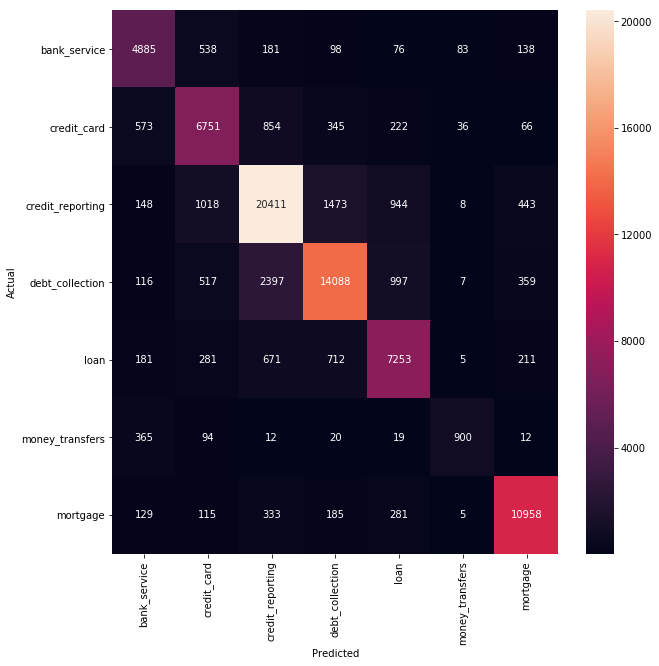

In [50]:
#svm_class = LinearSVC()
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
mnb_clf.fit(text_bow_train, y_train)
y_pred = mnb_clf.predict(text_bow_test)
features = vectorizer.get_feature_names()
print(metrics.classification_report(y_test, y_pred, target_names=features))
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=features, yticklabels=features)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Normalized Confusion Matrix

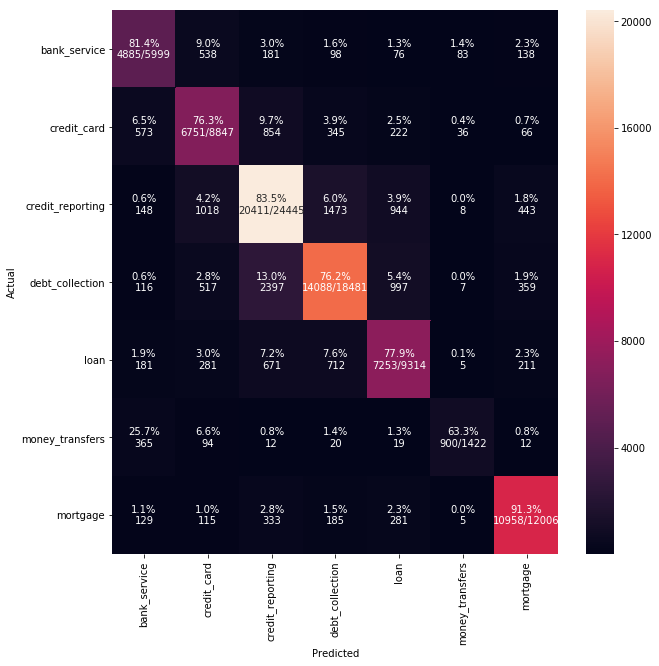

In [54]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

result = mnb_clf.score(text_bow_test, y_test)
y_pred = mnb_clf.predict(text_bow_test)

cm_analysis(y_test, y_pred, mnb_clf.classes_, ymap=None, figsize=(10,10))

### 7.5. Performance Metrics


In [56]:
print(metrics.classification_report(y_test, y_pred, target_names=features))

                  precision    recall  f1-score   support

    bank_service       0.76      0.81      0.79      5999
     credit_card       0.72      0.76      0.74      8847
credit_reporting       0.82      0.83      0.83     24445
 debt_collection       0.83      0.76      0.80     18481
            loan       0.74      0.78      0.76      9314
 money_transfers       0.86      0.63      0.73      1422
        mortgage       0.90      0.91      0.91     12006

     avg / total       0.81      0.81      0.81     80514



In [95]:
from io import StringIO
df = corps
df = df[pd.notnull(df['product_group'])]
df.columns = ['product_group', 'text']
df['complaint_id'] = df['product_group'].factorize()[0]
category_id_df = df[['product_group', 'complaint_id']].drop_duplicates().sort_values('complaint_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['complaint_id', 'product_group']].values)

### 7.6. N-gram Extraction

In [96]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for product_group, category_id in sorted(id_to_category.items()):
  features_chi2 = chi2(features,labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("# '{}':".format(category_id))
  print(".   Most correlated unigrams:\n.     {}".format('\n.     '.join(unigrams[-N:])))
  print(".   Most correlated bigrams:\n.     {}".format('\n.     '.join(bigrams[-N:])))
  print(".   Most correlated trigrams:\n.     {}".format('\n.     '.join(trigrams[-N:])))

# 'bank_service':
.   Most correlated unigrams:
.     deposit
.     overdraft
.   Most correlated bigrams:
.     overdraft fees
.     checking account
.   Most correlated trigrams:
.     charged overdraft fees
.     opened checking account
# 'credit_card':
.   Most correlated unigrams:
.     express
.     card
.   Most correlated bigrams:
.     american express
.     credit card
.   Most correlated trigrams:
.     credit card account
.     credit card company
# 'credit_reporting':
.   Most correlated unigrams:
.     experian
.     equifax
.   Most correlated bigrams:
.     credit file
.     credit report
.   Most correlated trigrams:
.     mistakes appear report
.     appear report understanding
# 'debt_collection':
.   Most correlated unigrams:
.     collection
.     debt
.   Most correlated bigrams:
.     collect debt
.     collection agency
.   Most correlated trigrams:
.     attempting collect debt
.     trying collect debt
# 'loan':
.   Most correlated unigrams:
.     loans
.     

## 8. Classifier Comparison

In [166]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB
#from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

### 8.1. Refresh Train and Test BOWs
We want to take a seemingly redundant steo and fresh the test and train sets that we transform into a bag-of-words, before we begin comparing classifiers.

In [59]:
# transforming into Bag-of-Words and hence textual data to numeric..
text_bow_train=bow_transformer.transform(X_train)#ONLY TRAINING DATA

In [60]:
# transforming into Bag-of-Words and hence textual data to numeric..
text_bow_test=bow_transformer.transform(X_test)#TEST DATA

### 8.2. Define Classifiers
First, we need to import the classiers from Scikit-Learn. Next, we define models as being comprised of a RandomForestClassifier, a LinearSVC(), a MultinomialNB(), and a LogisticRegression.

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    #RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    SGDClassifier(),
    RidgeClassifier(tol=1e-2, solver="sag"),
    Perceptron(max_iter=25),
    #KNeighborsClassifier(n_neighbors=10),
    LogisticRegression(random_state=0),
]

### 8.3. Execute the Classifiers
The code below will iterate (the "for" loop) through each classifier we defined in "models" above, fitting and scoring them for accuracy, and then plot them all on one accuracy plot for comparison. The plot is a combination of a boxplot and a stripplot. A strip plot is a scatterplot for categorical variables. It can be drawn on its own, but it a good complement to a box in cases where we want to show all observations along with some representation of the underlying distribution. Both plots are taken from the Seaborn module, and we abbreviate it as sns. From the plot, not that the Linear SVC, Multinomial Bayes, Ridge Regression and SGD Classifier, Perceptron, and Logistic Regression are in the range of good to strong classifiers in terms of accuracy. A Random Forest Classifier performs poorly with this data.

C:\Users\jeff\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\jeff\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\jeff\Anaconda\lib\site-pack

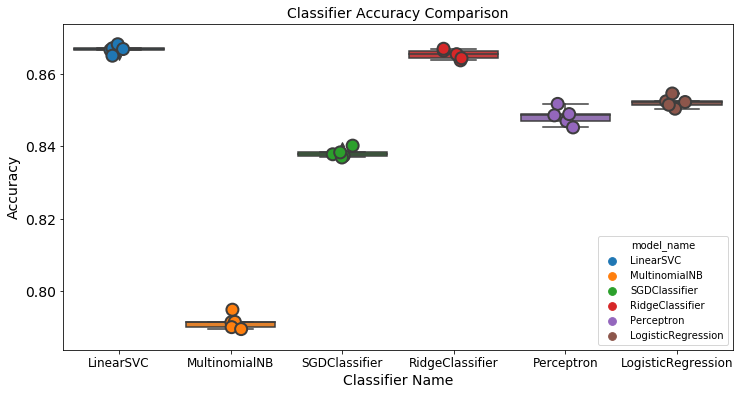

In [148]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
plt.figure(figsize=[12,6])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, hue='model_name',
              size=12, jitter=True, edgecolor="gray", linewidth=2)
plt.title('Classifier Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Classifier Name', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.show()

## 9. Model Analysis

Now we turn to our analysis of the models output and performance.

### 9.1. Anlysis of Model Performance

To start with, we can see on the graph above our models from left to
right: the random forest classification model, the support vector
machine (SVM), the multinomial Bayes classification mode, and the
multinomial logistic regression model. From the graph it appears that
the SVM provides the best performance. This is supported by the model
accuracy metric shown below, with about 87%.

In [149]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC             0.866703
LogisticRegression    0.852177
MultinomialNB         0.791452
Perceptron            0.848222
RidgeClassifier       0.865330
SGDClassifier         0.838076
Name: accuracy, dtype: float64

### 9.2. BOW Analysis with a Support Vector Machine (SVM)
Having concluded that the SVM is the best classifier, we now implement it shoing the full details and analysis, in the manner we first did with the Multinomial Naive Bayes Classifier. So, we first fit the data with the classifier as we dd before, we use a pipeline to prepare the data and to define the model

In [64]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

svm_clf = Pipeline([
     ('vect', vectorizer),
     ('tfidf', TfidfTransformer()),
     ('svm_clf', LinearSVC()),
 ])

In [68]:
svm_clf = LinearSVC()
svm_clf.fit(text_bow_train, y_train)

In [75]:
svm_score = svm_clf.score(text_bow_train, y_train)
svm_score

0.9389245526066452

In [78]:
y_pred = svm_clf.predict(text_bow_test)
y_pred_score = svm_clf.score(text_bow_test,y_test)
y_pred_score

0.8150632188190874

### 9.3. Confusion Matrices
The mean value for the SVM is better than that of the NBM, so we go an extra step in measuring its performance. Here we use what is called a "confusion matrix." A confusion matrix is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm, which is the SVM in this case. The confusion matrix itself is relatively simple to understand, but the related terminology can be confusing.

You may have heard these terms before, perhaps in a probability and statistics course.

1. True Positive: You predicted positive and it’s true, i.e., you predicted that a complaint corresponds to a loan and it actually is.

2. True Negative: You predicted negative and it’s true, i.e., you predicted that a complaint does not corresponds to a loan and it actually is not.

3. False Positive: (Type 1 Error) You predicted positive and it’s false, i.e.  you predicted that a complaint corresponds to a loan and it actually is not.

4. False Negative: (Type 2 Error) You predicted negative and it’s false. i.e.  you predicted that a complaint does not correspond to a loan and it does.

Remember, we describe predicted values as Positive and Negative and actual values as True and False.

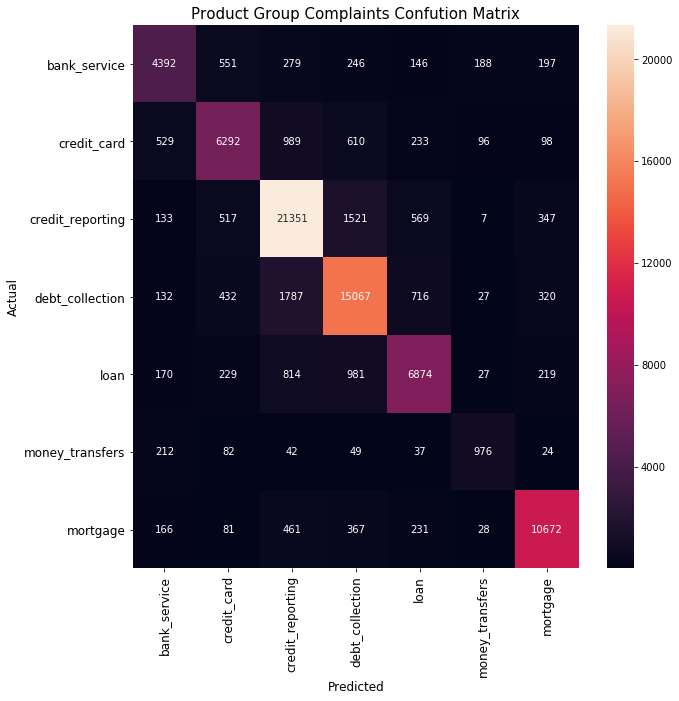

In [69]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.title('Product Group Complaints Confution Matrix', fontsize = 15)
plt.ylabel('Actual', fontsize = 12)
plt.xlabel('Predicted', fontsize = 12)
plt.show()

## 9.4. Normalized Confusion Matrix

Given the matrix below and 96.653% accuracy:

* 'Bank Service' is accurately 73.2% of the time, and incorrectly classifies as a 'credit card' complaint 9.2% of the time, as a 'credit reporting' complaint 4.7% of the time, and so on, as we move left to right on row one..
* 'Credit Card' is accurately 71.1% of the time, and is incorrectly classified as a 'credit reporting' complaint 11.2% of the time, as a 'debt collection' complaint 6.97 of the time, so on.
* 'Credit Reporting' is accurately 87.3% of the time, and incorrectly classified as a 'debt collection, complaint 6.2% of the time, as a 'loan' complaint 2.3% of the time, and so on.
* 'Debt Collection' is accurately 81.5% of the time, and incorrectly classied as a 'loan' 3.8% of the time, as a  'money transfer' complaint 0.1% of the time, and so on.
* 'Loan' is accurately 73.8% of the time, and incorrectly classied as a 'money transfer' 0.3% of the time, as a  'mortgage' complaint 2.4% of the time, and so on.
* 'Money Transfers' is accurately 68.6% of the time, and incorrectly classified as a 'mortgage' complaint 1.7% of the time, as a 'bank service' complaint 14.9% of the time and so on.
* 'Mortgages' is accurately 88.9% of the time, and incorrectly classified as a 'bank service' complaint 1.4% of the time, as a 'credit card' pmplaint 0.7%" of the time, and so on..

Accuracy - 81.5%, Recall = 77.7%, Precision is 79.6%, and the F1 Score is 78.6%

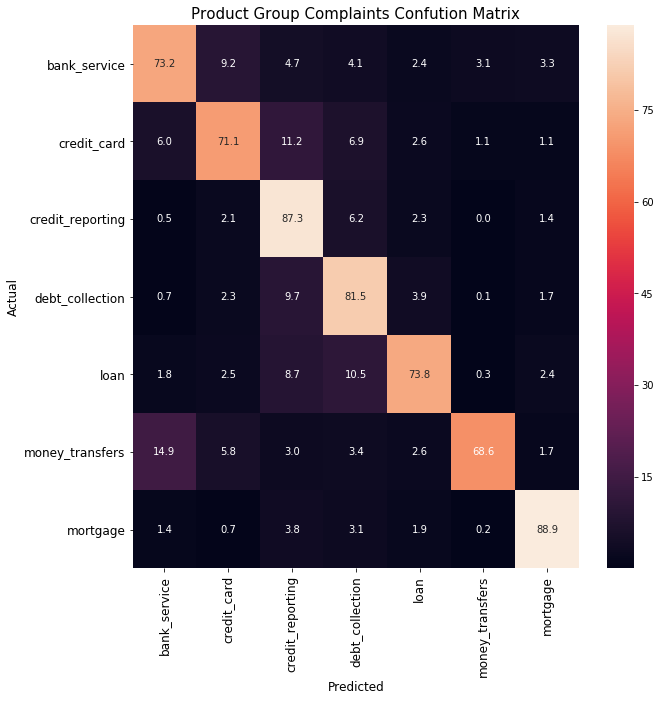

In [70]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_sum = np.sum(conf_mat, axis=1, keepdims=True)
cm_perc = conf_mat / conf_sum.astype(float) * 100
fig, ax = plt.subplots(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.heatmap(cm_perc, annot=True, fmt='.1f',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)

plt.title('Product Group Complaints Confution Matrix', fontsize = 15)
plt.ylabel('Actual', fontsize = 12)
plt.xlabel('Predicted', fontsize = 12)
plt.show()

In [72]:
result = svm_clf.score(text_bow_test, y_test)
print("Accuracy: %.3f%%" % (result*100.0))
y_pred = svm_clf.predict(text_bow_test)
print("F1 Score: ", f1_score(y_test, y_pred, average="macro"))
print("Precision Score: ", precision_score(y_test, y_pred, average="macro"))
print("Recall Score: ", recall_score(y_test, y_pred, average="macro")) 


Accuracy: 81.506%
F1 Score:  0.7861399924698416
Precision Score:  0.7953069447928314
Recall Score:  0.7778997642112603


### 9.5. Classification Report (Precision, Recall and F1–Score)
We just looked at the overall performance records for the SVM Classifier. Now we turn to the performance metrics as they pertain to each product group.

In [73]:
print(classification_report(y_test,y_pred))

                  precision    recall  f1-score   support

    bank_service       0.77      0.73      0.75      5999
     credit_card       0.77      0.71      0.74      8847
credit_reporting       0.83      0.87      0.85     24445
 debt_collection       0.80      0.82      0.81     18481
            loan       0.78      0.74      0.76      9314
 money_transfers       0.72      0.69      0.70      1422
        mortgage       0.90      0.89      0.89     12006

     avg / total       0.81      0.82      0.81     80514



# Conclusion

- The Classification and Random Forest models will have a tendency to over-predict. 
- While the Naive Bayes was trained having a lower performnce score (82,44),it will have more accurate predictions. 
- If we had an out-of-time sample, we could perform better validations on the three models. 
- In the mean time, we recommend the Naive Bayes Classification MOdel. 

#### Legend
- 0 = bank service
- 1 = credit card
- 2 = credit reporting
- 3 = debt collection
- 4 = loan
- 5 = money transfers
- 6 = mortgage

## 10. Ridge Regression Classifier

In [168]:
rg_clf = RidgeClassifier(tol=1e-2, solver="sag")
rg_clf.fit(text_bow_train, y_train)
rg_score = rg_clf.score(text_bow_train, y_train)
rg_score

0.7788583351963634

In [169]:
y_pred = rg_clf.predict(text_bow_test)
y_pred_score = rg_clf.score(text_bow_test,y_test)
y_pred_score

0.7733686067019401

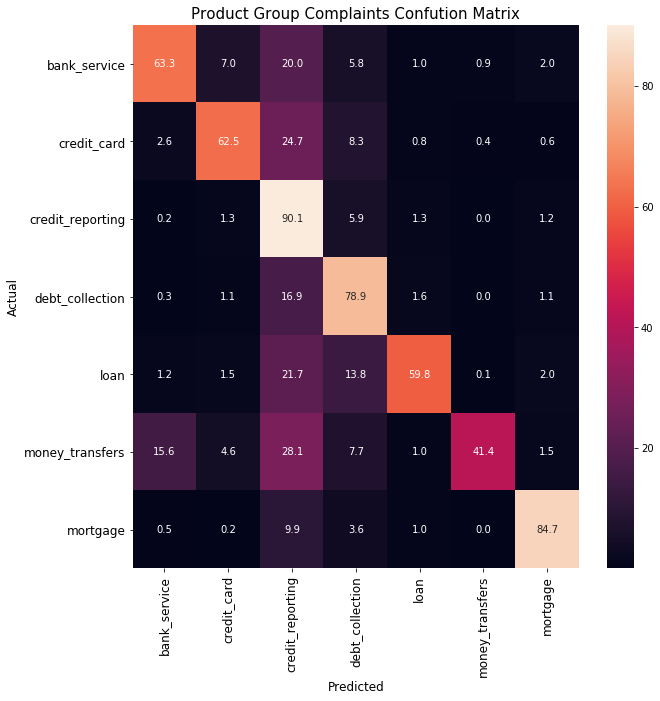

In [170]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_sum = np.sum(conf_mat, axis=1, keepdims=True)
cm_perc = conf_mat / conf_sum.astype(float) * 100
fig, ax = plt.subplots(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.heatmap(cm_perc, annot=True, fmt='.1f',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)

plt.title('Product Group Complaints Confution Matrix', fontsize = 15)
plt.ylabel('Actual', fontsize = 12)
plt.xlabel('Predicted', fontsize = 12)
plt.show()

In [171]:
result = rg_clf.score(text_bow_test, y_test)
print("Accuracy: %.3f%%" % (result*100.0))
y_pred = rg_clf.predict(text_bow_test)
print("F1 Score: ", f1_score(y_test, y_pred, average="macro"))
print("Precision Score: ", precision_score(y_test, y_pred, average="macro"))
print("Recall Score: ", recall_score(y_test, y_pred, average="macro")) 

Accuracy: 77.337%
F1 Score:  0.7333793046760552
Precision Score:  0.8199775631620732
Recall Score:  0.68677269782036


In [172]:
print(classification_report(y_test,y_pred))

                  precision    recall  f1-score   support

    bank_service       0.84      0.63      0.72      5999
     credit_card       0.83      0.63      0.71      8847
credit_reporting       0.69      0.90      0.78     24445
 debt_collection       0.77      0.79      0.78     18481
            loan       0.86      0.60      0.71      9314
 money_transfers       0.84      0.41      0.55      1422
        mortgage       0.92      0.85      0.88     12006

     avg / total       0.79      0.77      0.77     80514



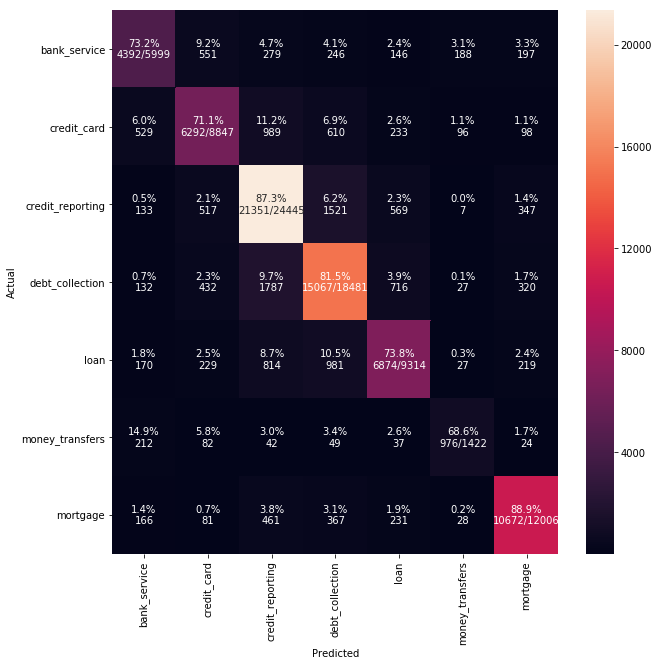

In [74]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

cm_analysis(y_test, y_pred, svm_clf.classes_, ymap=None, figsize=(10,10))

In [ ]:
jupyter nbconvert Complaint_Routing_Model_V3.ipynb --to pdf